# 03 - Transformer Block
Building up to a full transformer block: self-attention → multi-head → feedforward → **Block** with residual connections and LayerNorm.

Starting from where notebook 02 left off. All building blocks are carried forward so you can pick up at ~1:27:00 of Karpathy's video (residual connections).

Video: https://www.youtube.com/watch?v=kCc8FmEb1nY

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Check device
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')

# Read the dataset
with open('../data/shakespeare/input.txt', 'r') as f:
    text = f.read()

print(f'Length of dataset: {len(text):,} characters')
print(f'First 200 chars:\n{text[:200]}')

Using device: cpu
Length of dataset: 1,115,394 characters
First 200 chars:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [2]:
# Build character vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'Vocab size: {vocab_size}')

# Create encode/decode mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Encode the full dataset and split
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]
print(f'Train: {len(train_data):,} tokens, Val: {len(val_data):,} tokens')

Vocab size: 65


Train: 1,003,854 tokens, Val: 111,540 tokens


In [3]:
# Hyperparameters
batch_size = 32
block_size = 8
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
eval_iters = 200
n_embd = 32

torch.manual_seed(1337)

def get_batch(split):
    d = train_data if split == 'train' else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x = torch.stack([d[i:i+block_size] for i in ix])
    y = torch.stack([d[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Building blocks from notebook 02
These are the pieces we built previously: Head, MultiHeadAttention, FeedForward. All carried forward unchanged.

In [4]:
class Head(nn.Module):
    """One head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B,T,head_size)
        q = self.query(x) # (B,T,head_size)

        # compute attention scores
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  # (B,T,T)

        # weighted aggregation of values
        v = self.value(x)  # (B,T,head_size)
        out = wei @ v      # (B,T,head_size)
        return out


class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention running in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)


class FeedForward(nn.Module):
    """A simple linear layer followed by non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

## Baseline: Multi-head attention + feedforward (from notebook 02)
This is where we left off — `AttentionWithFeedForwardModel` from notebook 02, reproduced here as our starting point. Val loss was ~2.24.

In [5]:
class AttentionWithFeedForwardModel(nn.Module):
    """Baseline from notebook 02 — multi-head attention + feedforward, no blocks yet"""

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_heads = MultiHeadAttention(4, n_embd//4)  # 4 heads x 8 dims = 32
        self.ffwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.sa_heads(x) # apply multi-head self-attention (B,T,C)
        x = self.ffwd(x) # apply feedforward (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B,C)
            probs = F.softmax(logits, dim=-1) # (B,C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            idx = torch.cat((idx, idx_next), dim=1) # (B,T+1)
        return idx

model = AttentionWithFeedForwardModel().to(device)
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

Parameters: 8,609


In [6]:
# Train to verify we match notebook 02 baseline (~2.24 val loss)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

losses = estimate_loss(model)
print(f"\nBaseline final: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

step 0: train loss 4.1996, val loss 4.1995


step 500: train loss 2.5993, val loss 2.6077


step 1000: train loss 2.4629, val loss 2.4651


step 1500: train loss 2.3974, val loss 2.3951


step 2000: train loss 2.3297, val loss 2.3470


step 2500: train loss 2.3018, val loss 2.3221


step 3000: train loss 2.2828, val loss 2.2936


step 3500: train loss 2.2495, val loss 2.2721


step 4000: train loss 2.2435, val loss 2.2468


step 4500: train loss 2.2286, val loss 2.2411



Baseline final: train loss 2.2187, val loss 2.2472


In [7]:
# Generate from baseline
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print("Baseline (multi-head + feedforward) output:")
print(decode(model.generate(context, max_new_tokens=300)[0].tolist()))

Baseline (multi-head + feedforward) output:



Acled! lepin,--
Thri, que bave?

DOWHENCHESOUNG:
I nove, bar
th aly plost yevest rail thep iciecl hat ine aing sor he meet! wome? withe beoteg noth and and woens eyothast fors;
Hard, to, to thre's the cey, frand whim fbytaet' dlicee ad it cantult to bat ae, alend con are: tith pli!

Lornd third sean


### Baseline confirmed: val loss ~2.24

This matches where we left off in notebook 02 — multi-head attention + feedforward with 8.6K parameters. Everything from here improves on this baseline.

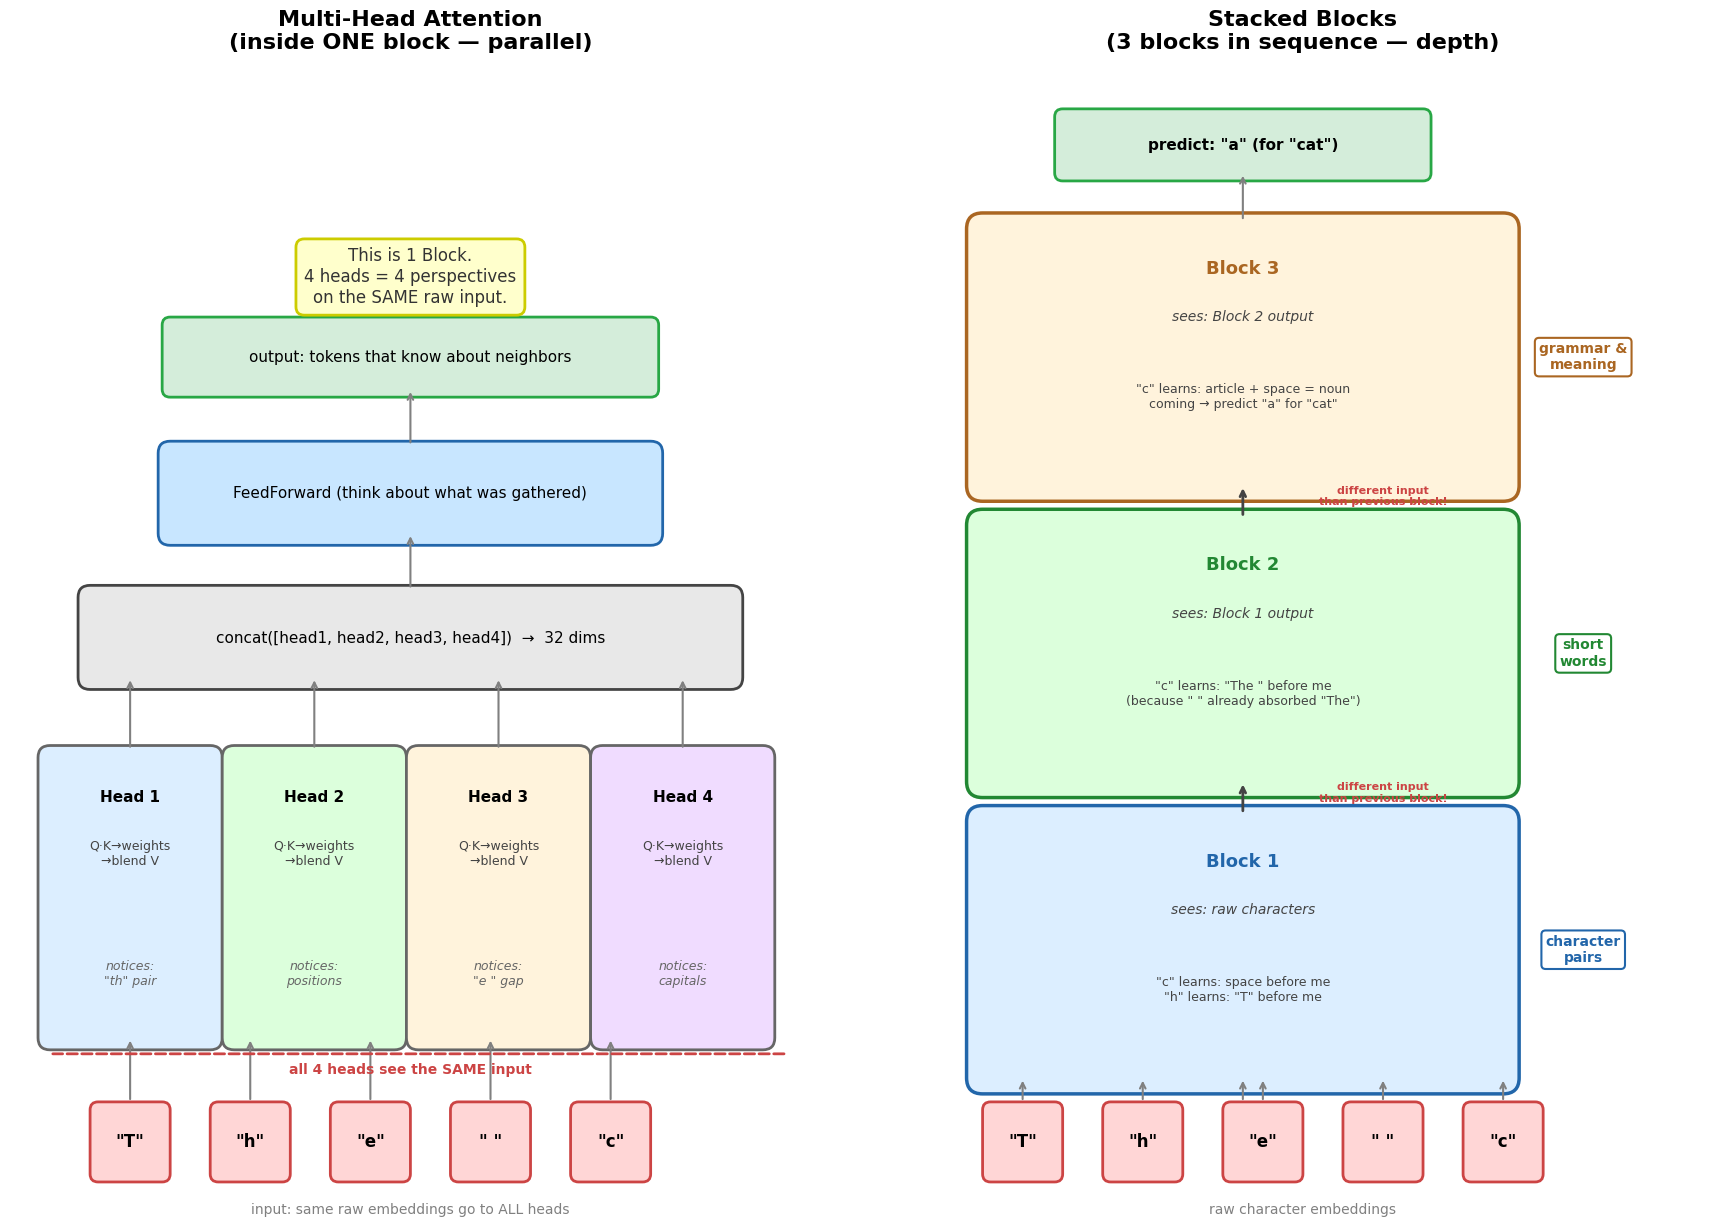

Saved to ../diagrams/multihead_vs_stacked_blocks.png


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# ============================================================
# LEFT: Multi-Head Attention (what happens INSIDE one block)
# ============================================================
ax = axes[0]
ax.set_xlim(0, 10)
ax.set_ylim(0, 14)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Multi-Head Attention\n(inside ONE block — parallel)', fontsize=16, fontweight='bold', pad=20)

# Input tokens at bottom
tokens = ['T', 'h', 'e', ' ', 'c']
token_x = [1.5, 3, 4.5, 6, 7.5]
for i, (tx, tok) in enumerate(zip(token_x, tokens)):
    ax.add_patch(patches.FancyBboxPatch((tx-0.4, 0.3), 0.8, 0.8, boxstyle="round,pad=0.1",
                 facecolor='#FFD6D6', edgecolor='#CC4444', linewidth=2))
    ax.text(tx, 0.7, f'"{tok}"', ha='center', va='center', fontsize=12, fontweight='bold')

ax.text(5, -0.2, 'input: same raw embeddings go to ALL heads', ha='center', fontsize=10, color='gray')

# Arrow up from tokens
for tx in token_x:
    ax.annotate('', xy=(tx, 2.0), xytext=(tx, 1.2),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# The 4 heads side by side
head_colors = ['#DCEEFF', '#DCFFDC', '#FFF3DC', '#F0DCFF']
head_labels = ['Head 1', 'Head 2', 'Head 3', 'Head 4']
head_what = ['"th" pair', 'positions', '"e " gap', 'capitals']

for i, (color, label, what) in enumerate(zip(head_colors, head_labels, head_what)):
    x_start = 0.5 + i * 2.3
    # Head box
    ax.add_patch(patches.FancyBboxPatch((x_start, 2.0), 2.0, 3.5, boxstyle="round,pad=0.15",
                 facecolor=color, edgecolor='#666666', linewidth=2))
    ax.text(x_start + 1.0, 5.0, label, ha='center', va='center', fontsize=11, fontweight='bold')
    ax.text(x_start + 1.0, 4.3, 'Q·K→weights\n→blend V', ha='center', va='center', fontsize=9, color='#444')
    ax.text(x_start + 1.0, 2.8, f'notices:\n{what}', ha='center', va='center', fontsize=9,
            color='#666', style='italic')

# "same input" bracket
ax.annotate('', xy=(0.5, 1.8), xytext=(9.7, 1.8),
            arrowprops=dict(arrowstyle='-', color='#CC4444', lw=2, linestyle='--'))
ax.text(5, 1.55, 'all 4 heads see the SAME input', ha='center', fontsize=10, color='#CC4444', fontweight='bold')

# Arrows up from heads to concat
for i in range(4):
    x_mid = 0.5 + i * 2.3 + 1.0
    ax.annotate('', xy=(x_mid, 6.5), xytext=(x_mid, 5.6),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Concat box
ax.add_patch(patches.FancyBboxPatch((1.0, 6.5), 8.0, 1.0, boxstyle="round,pad=0.15",
             facecolor='#E8E8E8', edgecolor='#444444', linewidth=2))
ax.text(5.0, 7.0, 'concat([head1, head2, head3, head4])  →  32 dims', ha='center', va='center', fontsize=11)

# Arrow to feedforward
ax.annotate('', xy=(5.0, 8.3), xytext=(5.0, 7.6),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Feedforward box
ax.add_patch(patches.FancyBboxPatch((2.0, 8.3), 6.0, 1.0, boxstyle="round,pad=0.15",
             facecolor='#C8E6FF', edgecolor='#2266AA', linewidth=2))
ax.text(5.0, 8.8, 'FeedForward (think about what was gathered)', ha='center', va='center', fontsize=11)

# Arrow to output
ax.annotate('', xy=(5.0, 10.1), xytext=(5.0, 9.4),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Output
ax.add_patch(patches.FancyBboxPatch((2.0, 10.1), 6.0, 0.8, boxstyle="round,pad=0.1",
             facecolor='#D4EDDA', edgecolor='#28A745', linewidth=2))
ax.text(5.0, 10.5, 'output: tokens that know about neighbors', ha='center', va='center', fontsize=11)

ax.text(5.0, 11.5, 'This is 1 Block.\n4 heads = 4 perspectives\non the SAME raw input.', 
        ha='center', va='center', fontsize=12, color='#333',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#FFFFCC', edgecolor='#CCCC00', linewidth=2))

# ============================================================
# RIGHT: Stacked Blocks (what happens when you chain blocks)
# ============================================================
ax = axes[1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 14)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Stacked Blocks\n(3 blocks in sequence — depth)', fontsize=16, fontweight='bold', pad=20)

# Input tokens at bottom
for i, (tx, tok) in enumerate(zip(token_x, tokens)):
    ax.add_patch(patches.FancyBboxPatch((tx-0.4, 0.3), 0.8, 0.8, boxstyle="round,pad=0.1",
                 facecolor='#FFD6D6', edgecolor='#CC4444', linewidth=2))
    ax.text(tx, 0.7, f'"{tok}"', ha='center', va='center', fontsize=12, fontweight='bold')

ax.text(5, -0.2, 'raw character embeddings', ha='center', fontsize=10, color='gray')

# Arrows up
for tx in token_x:
    ax.annotate('', xy=(tx, 1.5), xytext=(tx, 1.2),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Block 1
block_data = [
    (1.5, '#DCEEFF', '#2266AA', 'Block 1', 'sees: raw characters',
     '"c" learns: space before me\n"h" learns: "T" before me',
     'character\npairs'),
    (5.2, '#DCFFDC', '#228833', 'Block 2', 'sees: Block 1 output',
     '"c" learns: "The " before me\n(because " " already absorbed "The")',
     'short\nwords'),
    (8.9, '#FFF3DC', '#AA6622', 'Block 3', 'sees: Block 2 output',
     '"c" learns: article + space = noun\ncoming → predict "a" for "cat"',
     'grammar &\nmeaning'),
]

for i, (y_start, bg, edge, title, sees, learns, abstraction) in enumerate(block_data):
    # Block box
    ax.add_patch(patches.FancyBboxPatch((1.0, y_start), 6.5, 3.2, boxstyle="round,pad=0.2",
                 facecolor=bg, edgecolor=edge, linewidth=2.5))
    
    # Title
    ax.text(4.25, y_start + 2.7, title, ha='center', va='center', fontsize=13, fontweight='bold', color=edge)
    
    # What it sees
    ax.text(4.25, y_start + 2.1, sees, ha='center', va='center', fontsize=10, color='#444', style='italic')
    
    # What it learns
    ax.text(4.25, y_start + 1.1, learns, ha='center', va='center', fontsize=9, color='#444')
    
    # Abstraction label on right
    ax.text(8.5, y_start + 1.6, abstraction, ha='center', va='center', fontsize=10,
            fontweight='bold', color=edge,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=edge, linewidth=1.5))
    
    # Arrow between blocks
    if i < 2:
        next_y = block_data[i+1][0]
        ax.annotate('', xy=(4.25, next_y), xytext=(4.25, y_start + 3.3),
                    arrowprops=dict(arrowstyle='->', color='#444', lw=2))
        ax.text(6.0, y_start + 3.45, 'different input\nthan previous block!', ha='center', fontsize=8,
                color='#CC4444', fontweight='bold')

# Arrow from input to block 1
ax.annotate('', xy=(4.25, 1.5), xytext=(4.25, 1.2),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Output arrow and box
ax.annotate('', xy=(4.25, 12.8), xytext=(4.25, 12.2),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
ax.add_patch(patches.FancyBboxPatch((2.0, 12.8), 4.5, 0.7, boxstyle="round,pad=0.1",
             facecolor='#D4EDDA', edgecolor='#28A745', linewidth=2))
ax.text(4.25, 13.15, 'predict: "a" (for "cat")', ha='center', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../diagrams/multihead_vs_stacked_blocks.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved to ../diagrams/multihead_vs_stacked_blocks.png")

## The Block: Residual Connections + LayerNorm
Each Block = one round of "communicate then think." Two key additions:
- **Residual connections** (`x = x + ...`) — keep gradients alive through deep stacks. Without them, early layers stop learning.
- **LayerNorm** — normalizes values before each operation so softmax doesn't saturate and numbers stay well-behaved.

This is the **pre-norm** variant (LayerNorm *before* attention/feedforward, not after), which is what modern GPTs use.

In [8]:
class Block(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # residual + layernorm → attention
        x = x + self.ffwd(self.ln2(x))  # residual + layernorm → feedforward
        return x

## TransformerBlockModel: 4 stacked blocks
Replaces the flat `sa_heads + ffwd` with `nn.Sequential(Block, Block, Block, Block)`. Each block has its own multi-head attention, feedforward, residual connections, and LayerNorm. Final LayerNorm at the end of all blocks.

Parameter count jumps from 8.6K to 21.6K — each block has its own set of attention weights, feedforward weights, and LayerNorm parameters.

In [9]:
class TransformerBlockModel(nn.Module):
    """4 stacked transformer blocks with residual connections and LayerNorm"""

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # apply 4 transformer blocks (B,T,C)
        x = self.ln_f(x) # final layer norm (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B,C)
            probs = F.softmax(logits, dim=-1) # (B,C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            idx = torch.cat((idx, idx_next), dim=1) # (B,T+1)
        return idx

model = TransformerBlockModel().to(device)
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

Parameters: 21,569


In [10]:
# Train the 4-block transformer model
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

losses = estimate_loss(model)
print(f"\n4-block final: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

step 0: train loss 4.2995, val loss 4.3099


step 500: train loss 2.4813, val loss 2.4724


step 1000: train loss 2.3256, val loss 2.3357


step 1500: train loss 2.2569, val loss 2.2872


step 2000: train loss 2.2244, val loss 2.2329


step 2500: train loss 2.1846, val loss 2.2149


step 3000: train loss 2.1580, val loss 2.1846


step 3500: train loss 2.1169, val loss 2.1726


step 4000: train loss 2.1194, val loss 2.1645


step 4500: train loss 2.0907, val loss 2.1571



4-block final: train loss 2.0896, val loss 2.1358


In [11]:
# Generate — compare with single-block baseline above
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print("4-block transformer output:")
print(decode(model.generate(context, max_new_tokens=300)[0].tolist()))

4-block transformer output:



To him ford ut preopeet hale brved, vy loot our,
Sthat and py on them nof, hather off dounce a wo hrist on as moster him.

RATHENME LINGIO:
In tit bee.
Is EVONCINCANFIOMINTIO:
Nrales it an with thous I midle modequ of lotent your, were wiet und with locks
I soolr.

WONTIN:
And k dagus shall
Yroe die


### Loss: 2.24 → 2.13 (4 stacked transformer blocks)

A big win from depth! Going from a flat attention+feedforward to 4 stacked blocks drops val loss by 0.11. The model now has 21.6K parameters (up from 8.6K) and each block builds on the previous block's output — not the raw input.

**Why depth compounds:** Block 1 learns character patterns. Block 2 sees Block 1's enriched representations and can learn word-level patterns. Block 3 sees Block 2's output and can learn grammar. Each layer of abstraction enables the next. This is the same principle that makes GPT-3's 96 layers so powerful.

Notice the generated text: longer coherent sequences, more real-looking speaker names, and punctuation landing in more natural positions.

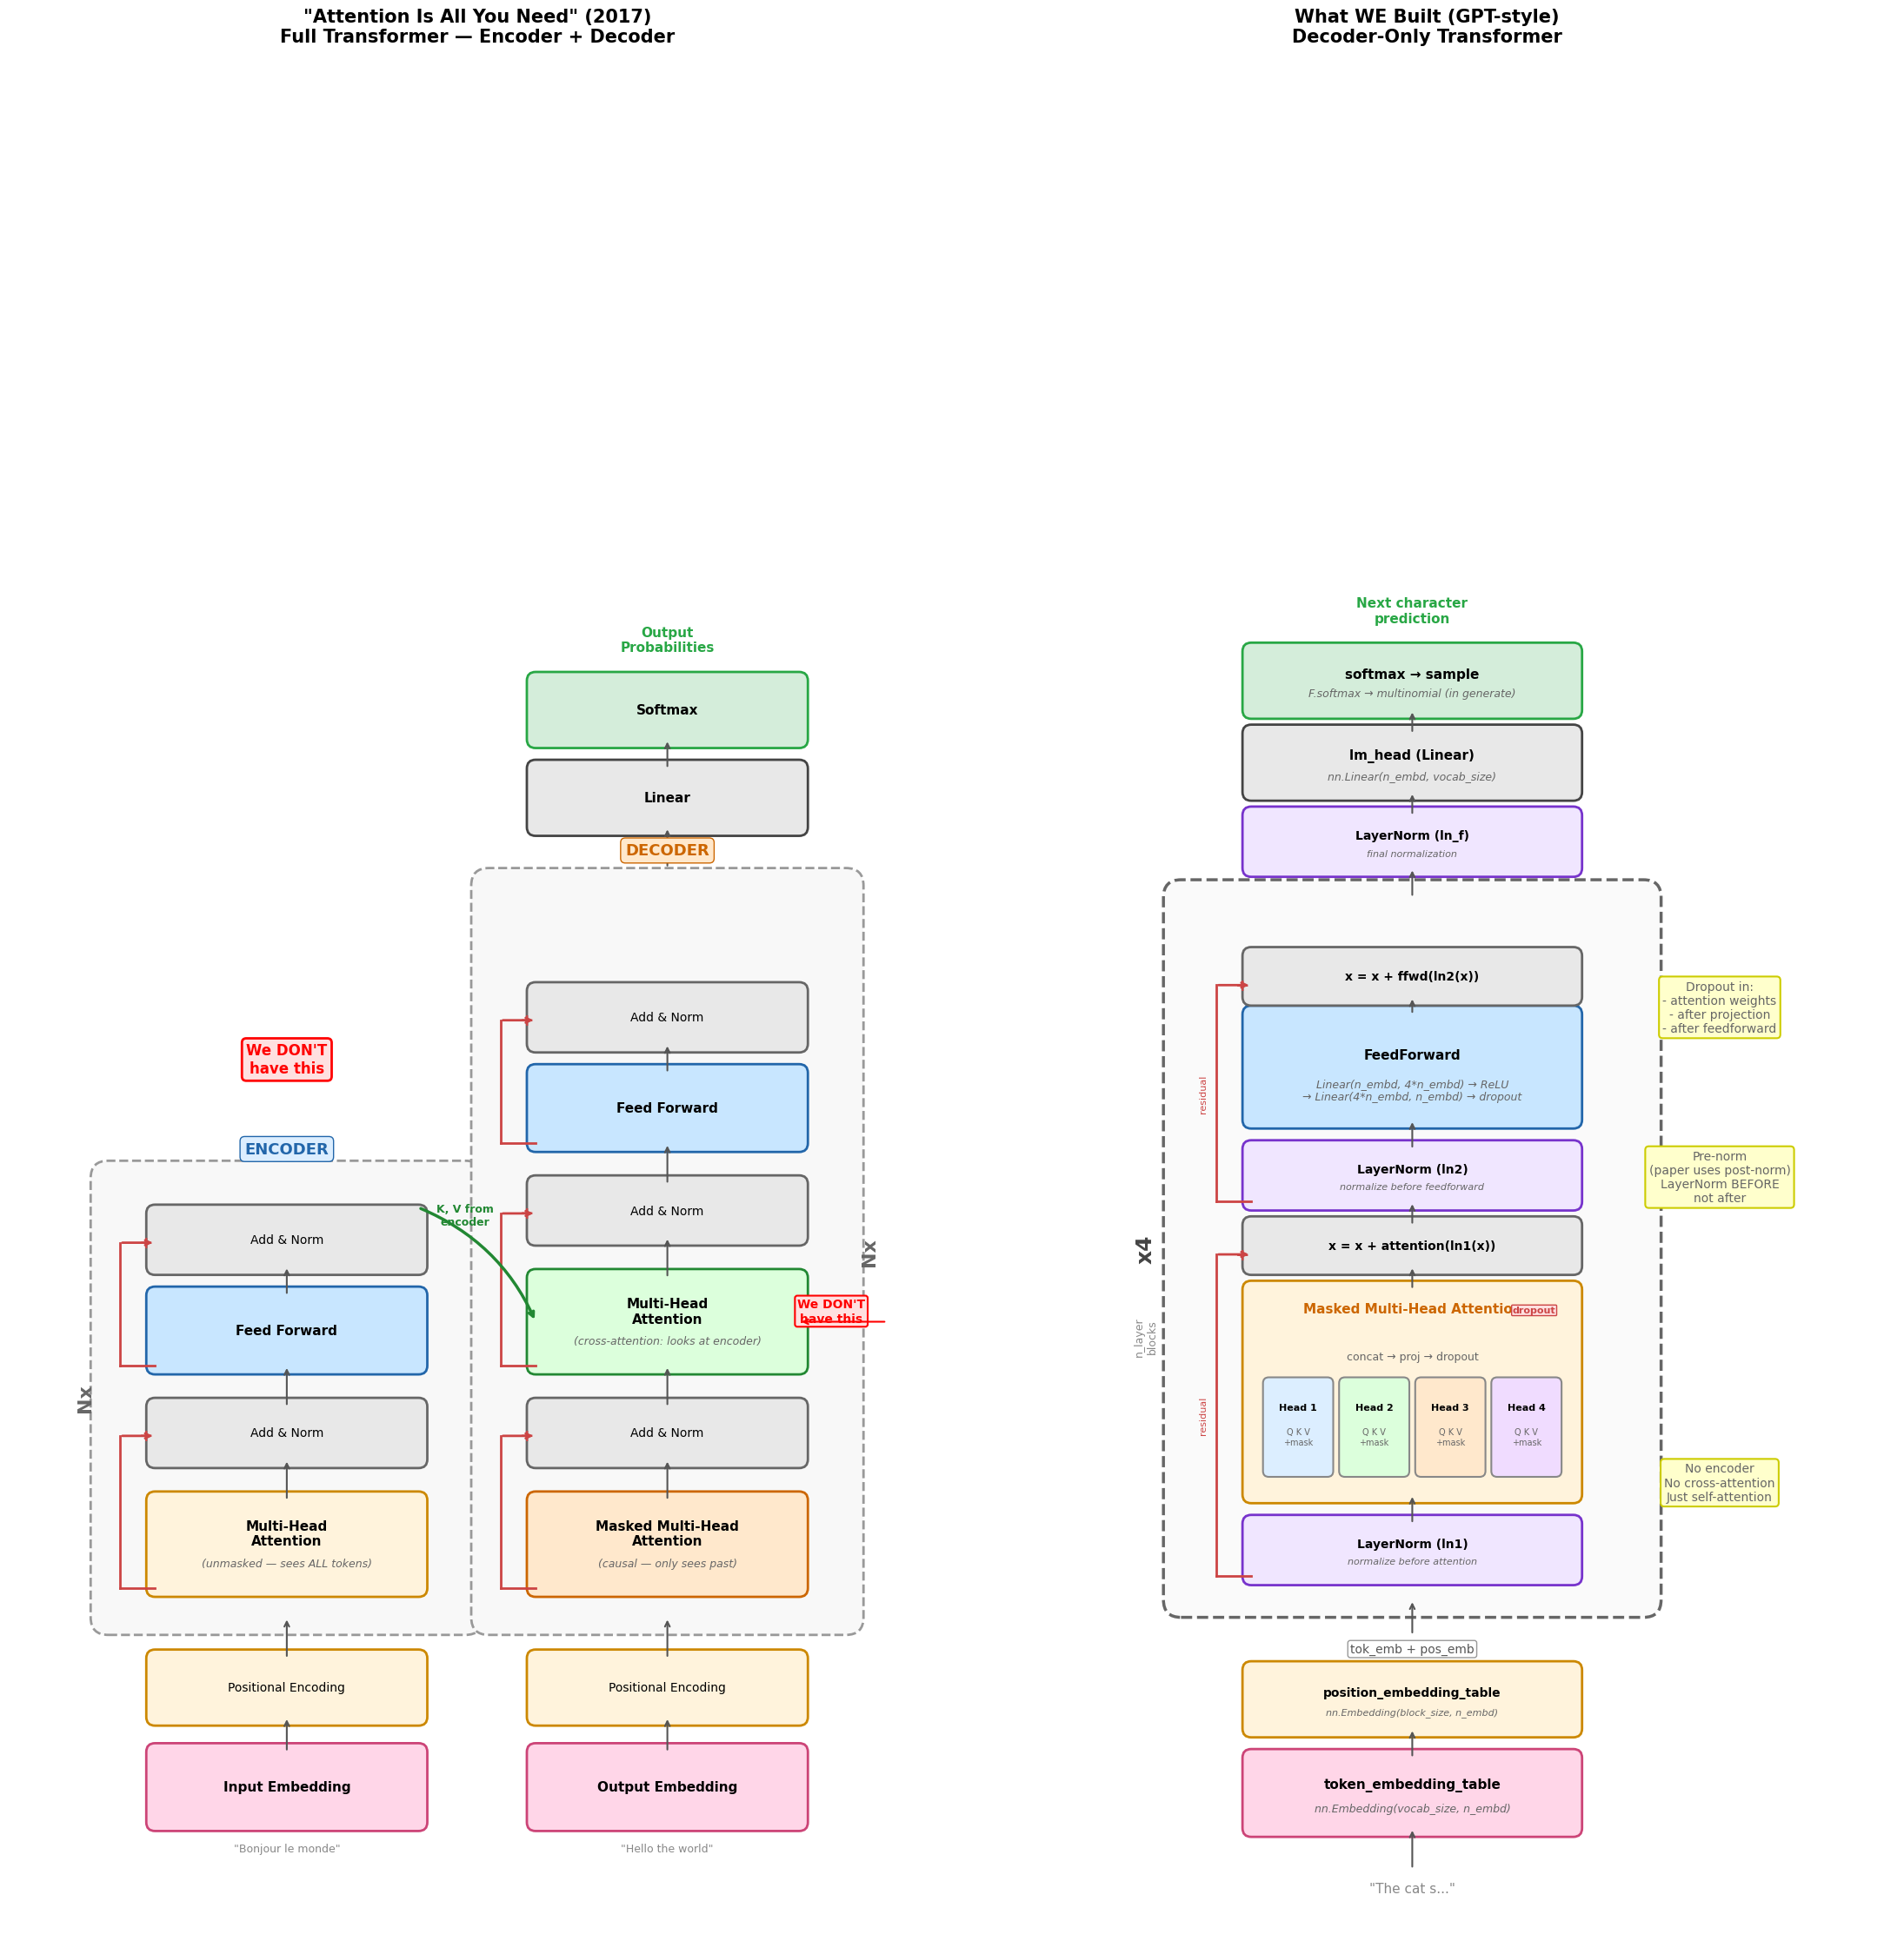

Saved to ../diagrams/our_architecture_vs_paper.png


In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, axes = plt.subplots(1, 2, figsize=(22, 28))

# ============================================================
# Helper functions
# ============================================================
def draw_box(ax, x, y, w, h, text, facecolor, edgecolor, fontsize=10, textcolor='black', bold=False, subtext=None, subtextcolor='#666'):
    ax.add_patch(patches.FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.15",
                 facecolor=facecolor, edgecolor=edgecolor, linewidth=2))
    weight = 'bold' if bold else 'normal'
    if subtext:
        ax.text(x + w/2, y + h*0.62, text, ha='center', va='center', fontsize=fontsize, fontweight=weight, color=textcolor)
        ax.text(x + w/2, y + h*0.28, subtext, ha='center', va='center', fontsize=fontsize-2, color=subtextcolor, style='italic')
    else:
        ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=fontsize, fontweight=weight, color=textcolor)

def draw_arrow(ax, x1, y1, x2, y2, color='#555', lw=1.5):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color=color, lw=lw))

def draw_residual(ax, x_box, y_start, y_end, w_box, color='#CC4444', label=None):
    """Draw a residual skip connection arrow on the left side of a box"""
    x_left = x_box - 0.6
    # Vertical line up
    ax.plot([x_left, x_left], [y_start, y_end], color=color, lw=2, linestyle='-')
    # Horizontal line from start
    ax.plot([x_left, x_box], [y_start, y_start], color=color, lw=2)
    # Arrow into end with + symbol
    ax.annotate('', xy=(x_box, y_end), xytext=(x_left, y_end),
                arrowprops=dict(arrowstyle='->', color=color, lw=2))
    # Plus symbol
    ax.text(x_box - 0.15, y_end, '+', ha='center', va='center', fontsize=14, fontweight='bold', color=color)
    if label:
        ax.text(x_left - 0.15, (y_start + y_end) / 2, label, ha='right', va='center', fontsize=8,
                color=color, rotation=90)


# ============================================================
# LEFT: Full "Attention Is All You Need" paper architecture
# ============================================================
ax = axes[0]
ax.set_xlim(-2, 14)
ax.set_ylim(-2, 30)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('"Attention Is All You Need" (2017)\nFull Transformer — Encoder + Decoder',
             fontsize=15, fontweight='bold', pad=20)

# --- ENCODER (left column) ---
enc_x = 0.5
enc_w = 4.5

# Input Embedding
draw_box(ax, enc_x, 0, enc_w, 1.2, 'Input Embedding', '#FFD6E8', '#CC4477', fontsize=11, bold=True)
ax.text(enc_x + enc_w/2, -0.5, '"Bonjour le monde"', ha='center', fontsize=9, color='#888')

# Positional Encoding
draw_arrow(ax, enc_x + enc_w/2, 1.2, enc_x + enc_w/2, 1.8, color='#555')
draw_box(ax, enc_x, 1.8, enc_w, 1.0, 'Positional Encoding', '#FFF3DC', '#CC8800', fontsize=10)

# Nx bracket for encoder
draw_arrow(ax, enc_x + enc_w/2, 2.8, enc_x + enc_w/2, 3.5, color='#555')

# Encoder block outline
enc_block_y = 3.5
enc_block_h = 7.5
ax.add_patch(patches.FancyBboxPatch((enc_x - 0.8, enc_block_y), enc_w + 1.6, enc_block_h,
             boxstyle="round,pad=0.3", facecolor='#F8F8F8', edgecolor='#999', linewidth=2, linestyle='--'))
ax.text(enc_x - 1.2, enc_block_y + enc_block_h/2, 'Nx', ha='center', va='center', fontsize=16,
        fontweight='bold', color='#666', rotation=90)

# Multi-Head Attention (UNMASKED)
draw_box(ax, enc_x, 4.0, enc_w, 1.5, 'Multi-Head\nAttention', '#FFF3DC', '#CC8800', fontsize=11, bold=True,
         subtext='(unmasked — sees ALL tokens)')

# Add & Norm
draw_arrow(ax, enc_x + enc_w/2, 5.5, enc_x + enc_w/2, 6.2, color='#555')
draw_box(ax, enc_x, 6.2, enc_w, 0.9, 'Add & Norm', '#E8E8E8', '#666', fontsize=10)
draw_residual(ax, enc_x, 4.0, 6.6, enc_w, color='#CC4444')

# Feed Forward
draw_arrow(ax, enc_x + enc_w/2, 7.1, enc_x + enc_w/2, 7.8, color='#555')
draw_box(ax, enc_x, 7.8, enc_w, 1.2, 'Feed Forward', '#C8E6FF', '#2266AA', fontsize=11, bold=True)

# Add & Norm
draw_arrow(ax, enc_x + enc_w/2, 9.0, enc_x + enc_w/2, 9.5, color='#555')
draw_box(ax, enc_x, 9.5, enc_w, 0.9, 'Add & Norm', '#E8E8E8', '#666', fontsize=10)
draw_residual(ax, enc_x, 7.8, 9.9, enc_w, color='#CC4444')

ax.text(enc_x + enc_w/2, 11.5, 'ENCODER', ha='center', va='center', fontsize=13,
        fontweight='bold', color='#2266AA',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='#DCEEFF', edgecolor='#2266AA'))

# --- DECODER (right column) ---
dec_x = 7.0
dec_w = 4.5

# Output Embedding
draw_box(ax, dec_x, 0, dec_w, 1.2, 'Output Embedding', '#FFD6E8', '#CC4477', fontsize=11, bold=True)
ax.text(dec_x + dec_w/2, -0.5, '"Hello the world"', ha='center', fontsize=9, color='#888')

# Positional Encoding
draw_arrow(ax, dec_x + dec_w/2, 1.2, dec_x + dec_w/2, 1.8, color='#555')
draw_box(ax, dec_x, 1.8, dec_w, 1.0, 'Positional Encoding', '#FFF3DC', '#CC8800', fontsize=10)

draw_arrow(ax, dec_x + dec_w/2, 2.8, dec_x + dec_w/2, 3.5, color='#555')

# Decoder block outline
dec_block_y = 3.5
dec_block_h = 12.5
ax.add_patch(patches.FancyBboxPatch((dec_x - 0.8, dec_block_y), dec_w + 1.6, dec_block_h,
             boxstyle="round,pad=0.3", facecolor='#F8F8F8', edgecolor='#999', linewidth=2, linestyle='--'))
ax.text(dec_x + dec_w + 1.2, dec_block_y + dec_block_h/2, 'Nx', ha='center', va='center', fontsize=16,
        fontweight='bold', color='#666', rotation=90)

# Masked Multi-Head Attention
draw_box(ax, dec_x, 4.0, dec_w, 1.5, 'Masked Multi-Head\nAttention', '#FFE8CC', '#CC6600', fontsize=11, bold=True,
         subtext='(causal — only sees past)')

# Add & Norm
draw_arrow(ax, dec_x + dec_w/2, 5.5, dec_x + dec_w/2, 6.2, color='#555')
draw_box(ax, dec_x, 6.2, dec_w, 0.9, 'Add & Norm', '#E8E8E8', '#666', fontsize=10)
draw_residual(ax, dec_x, 4.0, 6.6, dec_w, color='#CC4444')

# Cross-Attention (connects encoder to decoder)
draw_arrow(ax, dec_x + dec_w/2, 7.1, dec_x + dec_w/2, 7.8, color='#555')
draw_box(ax, dec_x, 7.8, dec_w, 1.5, 'Multi-Head\nAttention', '#DCFFDC', '#228833', fontsize=11, bold=True,
         subtext='(cross-attention: looks at encoder)')

# Arrow from encoder to cross-attention
ax.annotate('', xy=(dec_x, 8.55), xytext=(enc_x + enc_w, 10.5),
            arrowprops=dict(arrowstyle='->', color='#228833', lw=2.5, connectionstyle='arc3,rad=-0.2'))
ax.text(5.8, 10.2, 'K, V from\nencoder', ha='center', fontsize=9, color='#228833', fontweight='bold')

# Add & Norm
draw_arrow(ax, dec_x + dec_w/2, 9.3, dec_x + dec_w/2, 10.0, color='#555')
draw_box(ax, dec_x, 10.0, dec_w, 0.9, 'Add & Norm', '#E8E8E8', '#666', fontsize=10)
draw_residual(ax, dec_x, 7.8, 10.4, dec_w, color='#CC4444')

# Feed Forward
draw_arrow(ax, dec_x + dec_w/2, 10.9, dec_x + dec_w/2, 11.6, color='#555')
draw_box(ax, dec_x, 11.6, dec_w, 1.2, 'Feed Forward', '#C8E6FF', '#2266AA', fontsize=11, bold=True)

# Add & Norm
draw_arrow(ax, dec_x + dec_w/2, 12.8, dec_x + dec_w/2, 13.3, color='#555')
draw_box(ax, dec_x, 13.3, dec_w, 0.9, 'Add & Norm', '#E8E8E8', '#666', fontsize=10)
draw_residual(ax, dec_x, 11.6, 13.7, dec_w, color='#CC4444')

# Linear + Softmax at top
draw_arrow(ax, dec_x + dec_w/2, 16.3, dec_x + dec_w/2, 17.0, color='#555')
draw_box(ax, dec_x, 17.0, dec_w, 1.0, 'Linear', '#E8E8E8', '#444', fontsize=11, bold=True)
draw_arrow(ax, dec_x + dec_w/2, 18.0, dec_x + dec_w/2, 18.5, color='#555')
draw_box(ax, dec_x, 18.5, dec_w, 1.0, 'Softmax', '#D4EDDA', '#28A745', fontsize=11, bold=True)
ax.text(dec_x + dec_w/2, 20.0, 'Output\nProbabilities', ha='center', fontsize=11, fontweight='bold', color='#28A745')

ax.text(dec_x + dec_w/2, 16.6, 'DECODER', ha='center', va='center', fontsize=13,
        fontweight='bold', color='#CC6600',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFE8CC', edgecolor='#CC6600'))

# "We DON'T have" labels
ax.text(enc_x + enc_w/2, 12.8, 'We DON\'T\nhave this', ha='center', fontsize=12, color='red', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFE0E0', edgecolor='red', linewidth=2))

# Cross-attention X
ax.text(dec_x + dec_w/2 + 2.8, 8.55, 'We DON\'T\nhave this', ha='center', fontsize=10, color='red', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='#FFE0E0', edgecolor='red', linewidth=1.5))
ax.annotate('', xy=(dec_x + dec_w, 8.55), xytext=(dec_x + dec_w + 1.5, 8.55),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5))


# ============================================================
# RIGHT: What WE built (decoder-only GPT)
# ============================================================
ax = axes[1]
ax.set_xlim(-2, 14)
ax.set_ylim(-2, 30)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('What WE Built (GPT-style)\nDecoder-Only Transformer',
             fontsize=15, fontweight='bold', pad=20)

our_x = 3.0
our_w = 5.5

# Input characters
ax.text(our_x + our_w/2, -1.2, '"The cat s..."', ha='center', fontsize=11, color='#888')
draw_arrow(ax, our_x + our_w/2, -0.8, our_x + our_w/2, -0.1, color='#555')

# Token Embedding
draw_box(ax, our_x, -0.1, our_w, 1.2, 'token_embedding_table', '#FFD6E8', '#CC4477', fontsize=11, bold=True,
         subtext='nn.Embedding(vocab_size, n_embd)')

# Positional Embedding
draw_arrow(ax, our_x + our_w/2, 1.1, our_x + our_w/2, 1.6, color='#555')
draw_box(ax, our_x, 1.6, our_w, 1.0, 'position_embedding_table', '#FFF3DC', '#CC8800', fontsize=10, bold=True,
         subtext='nn.Embedding(block_size, n_embd)')

# + symbol
ax.text(our_x + our_w/2, 2.9, 'tok_emb + pos_emb', ha='center', fontsize=10, color='#555',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='#999'))

draw_arrow(ax, our_x + our_w/2, 3.2, our_x + our_w/2, 3.8, color='#555')

# Block outline — repeated N times
block_y = 3.8
block_h = 12.0
ax.add_patch(patches.FancyBboxPatch((our_x - 1.2, block_y), our_w + 2.4, block_h,
             boxstyle="round,pad=0.3", facecolor='#FAFAFA', edgecolor='#666', linewidth=2.5, linestyle='--'))
ax.text(our_x - 1.8, block_y + block_h/2, f'x{n_layer}', ha='center', va='center', fontsize=18,
        fontweight='bold', color='#444', rotation=90)
ax.text(our_x - 1.8, block_y + block_h/2 - 1.5, 'n_layer\nblocks', ha='center', va='center', fontsize=9, color='#888', rotation=90)

# --- Inside one Block ---
# LayerNorm 1
draw_box(ax, our_x, 4.2, our_w, 0.9, 'LayerNorm (ln1)', '#F0E6FF', '#7733CC', fontsize=10, bold=True,
         subtext='normalize before attention')

draw_arrow(ax, our_x + our_w/2, 5.1, our_x + our_w/2, 5.6, color='#555')

# Multi-Head Attention with heads shown
mha_y = 5.6
mha_h = 3.5
ax.add_patch(patches.FancyBboxPatch((our_x, mha_y), our_w, mha_h, boxstyle="round,pad=0.15",
             facecolor='#FFF3DC', edgecolor='#CC8800', linewidth=2))
ax.text(our_x + our_w/2, mha_y + mha_h - 0.4, 'Masked Multi-Head Attention', ha='center', fontsize=11,
        fontweight='bold', color='#CC6600')

# Show individual heads inside
head_w = 1.0
head_h = 1.5
head_colors = ['#DCEEFF', '#DCFFDC', '#FFE8CC', '#F0DCFF']
for i in range(4):
    hx = our_x + 0.3 + i * 1.3
    hy = mha_y + 0.4
    ax.add_patch(patches.FancyBboxPatch((hx, hy), head_w, head_h, boxstyle="round,pad=0.1",
                 facecolor=head_colors[i], edgecolor='#888', linewidth=1.5))
    ax.text(hx + head_w/2, hy + head_h*0.7, f'Head {i+1}', ha='center', fontsize=8, fontweight='bold')
    ax.text(hx + head_w/2, hy + head_h*0.3, 'Q K V\n+mask', ha='center', fontsize=7, color='#666')

# Dropout label inside MHA
ax.text(our_x + our_w - 0.3, mha_y + mha_h - 0.4, 'dropout', ha='right', fontsize=8,
        color='#CC4444', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.1', facecolor='#FFE0E0', edgecolor='#CC4444', linewidth=1))

# Projection label
ax.text(our_x + our_w/2, mha_y + 2.3, 'concat → proj → dropout', ha='center', fontsize=9, color='#666')

# Residual connection around attention
draw_residual(ax, our_x, 4.2, 9.7, our_w, color='#CC4444', label='residual')

# Add & residual merge
draw_arrow(ax, our_x + our_w/2, mha_y + mha_h, our_x + our_w/2, 9.5, color='#555')
draw_box(ax, our_x, 9.5, our_w, 0.7, 'x = x + attention(ln1(x))', '#E8E8E8', '#666', fontsize=10, bold=True)

draw_arrow(ax, our_x + our_w/2, 10.2, our_x + our_w/2, 10.6, color='#555')

# LayerNorm 2
draw_box(ax, our_x, 10.6, our_w, 0.9, 'LayerNorm (ln2)', '#F0E6FF', '#7733CC', fontsize=10, bold=True,
         subtext='normalize before feedforward')

draw_arrow(ax, our_x + our_w/2, 11.5, our_x + our_w/2, 12.0, color='#555')

# FeedForward
draw_box(ax, our_x, 12.0, our_w, 1.8, 'FeedForward', '#C8E6FF', '#2266AA', fontsize=11, bold=True,
         subtext='Linear(n_embd, 4*n_embd) → ReLU\n→ Linear(4*n_embd, n_embd) → dropout')

# Residual around feedforward
draw_residual(ax, our_x, 10.6, 14.3, our_w, color='#CC4444', label='residual')

# Add & residual merge
draw_arrow(ax, our_x + our_w/2, 13.8, our_x + our_w/2, 14.1, color='#555')
draw_box(ax, our_x, 14.1, our_w, 0.7, 'x = x + ffwd(ln2(x))', '#E8E8E8', '#666', fontsize=10, bold=True)

# --- After all blocks ---
draw_arrow(ax, our_x + our_w/2, block_y + block_h, our_x + our_w/2, 16.3, color='#555')

# Final LayerNorm
draw_box(ax, our_x, 16.3, our_w, 0.9, 'LayerNorm (ln_f)', '#F0E6FF', '#7733CC', fontsize=10, bold=True,
         subtext='final normalization')

# Linear head
draw_arrow(ax, our_x + our_w/2, 17.2, our_x + our_w/2, 17.6, color='#555')
draw_box(ax, our_x, 17.6, our_w, 1.0, 'lm_head (Linear)', '#E8E8E8', '#444', fontsize=11, bold=True,
         subtext='nn.Linear(n_embd, vocab_size)')

# Softmax (in generate)
draw_arrow(ax, our_x + our_w/2, 18.6, our_x + our_w/2, 19.0, color='#555')
draw_box(ax, our_x, 19.0, our_w, 1.0, 'softmax → sample', '#D4EDDA', '#28A745', fontsize=11, bold=True,
         subtext='F.softmax → multinomial (in generate)')

ax.text(our_x + our_w/2, 20.5, 'Next character\nprediction', ha='center', fontsize=11, fontweight='bold', color='#28A745')

# --- Annotations: what's different ---
ann_x = our_x + our_w + 0.5
ann_style = dict(boxstyle='round,pad=0.3', facecolor='#FFFFCC', edgecolor='#CCCC00', linewidth=1.5)

ax.text(ann_x + 2, 5.5, 'No encoder\nNo cross-attention\nJust self-attention', ha='center', fontsize=10,
        color='#666', bbox=ann_style)

ax.text(ann_x + 2, 10.6, 'Pre-norm\n(paper uses post-norm)\nLayerNorm BEFORE\nnot after', ha='center', fontsize=10,
        color='#666', bbox=ann_style)

ax.text(ann_x + 2, 13.5, 'Dropout in:\n- attention weights\n- after projection\n- after feedforward', ha='center', fontsize=10,
        color='#666', bbox=ann_style)

plt.tight_layout()
plt.savefig('../diagrams/our_architecture_vs_paper.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved to ../diagrams/our_architecture_vs_paper.png")

## Scaling up: dropout + more layers + bigger embeddings (~1:40:00 in video)

Time to go bigger. Three key improvements:
1. **Dropout** — randomly zeros out neurons during training to prevent overfitting
2. **More layers** (`n_layer=4`) — deeper network, configurable now instead of hardcoded
3. **Bigger embeddings** (`n_embd=64`) — each token gets a richer representation (was 32)
4. **4x feedforward expansion** — inner layer is 4× the embedding size (standard in transformers)
5. **Longer context** (`block_size=32`) — model sees more characters at once (was 8)

Note: Karpathy uses n_embd=384, n_layer=6, block_size=256 on GPU. We scale down for CPU training but the architecture is identical.

In [13]:
# --- Scaled-up hyperparameters ---
batch_size = 32
block_size = 32       # was 8 — model sees 32 chars of context now
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4  # lower lr for bigger model
eval_iters = 200
n_embd = 64           # was 32
n_head = 4
n_layer = 4
dropout = 0.2

torch.manual_seed(1337)
print(f"Config: n_embd={n_embd}, n_head={n_head}, n_layer={n_layer}, block_size={block_size}, dropout={dropout}")

Config: n_embd=64, n_head=4, n_layer=4, block_size=32, dropout=0.2


In [14]:
# --- Redefined building blocks with dropout ---

class Head(nn.Module):
    """One head of self-attention (now with dropout)"""

    def __init__(self, head_size):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)  # NEW: dropout on attention weights

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)  # NEW: randomly drop some attention connections
        v = self.value(x)
        out = wei @ v
        return out


class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel (now with projection + dropout)"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)  # NEW: projection layer back into residual stream
        self.dropout = nn.Dropout(dropout)       # NEW: dropout after projection

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))  # NEW: project and dropout
        return out


class FeedForward(nn.Module):
    """Linear layer with 4x expansion + ReLU + projection + dropout"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # NEW: 4x expansion (was 1x)
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # NEW: project back down
            nn.Dropout(dropout),              # NEW: dropout
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

print("Building blocks redefined with dropout ✓")

Building blocks redefined with dropout ✓


In [15]:
class ScaledTransformerModel(nn.Module):
    """Full GPT architecture — scaled up with dropout, bigger embeddings, longer context"""

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

model = ScaledTransformerModel().to(device)
param_count = sum(p.numel() for p in model.parameters())
print(f'Parameters: {param_count:,}')
print(f'Blocks: {n_layer}, Heads per block: {n_head}, Embedding dim: {n_embd}')

Parameters: 209,729
Blocks: 4, Heads per block: 4, Embedding dim: 64


In [16]:
# Train the scaled-up model
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

losses = estimate_loss(model)
print(f"\nScaled-up final: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

step 0: train loss 4.4107, val loss 4.4039


step 500: train loss 2.4892, val loss 2.4892


step 1000: train loss 2.3416, val loss 2.3411


step 1500: train loss 2.2281, val loss 2.2480


step 2000: train loss 2.1457, val loss 2.1695


step 2500: train loss 2.0928, val loss 2.1197


step 3000: train loss 2.0345, val loss 2.0820


step 3500: train loss 1.9962, val loss 2.0532


step 4000: train loss 1.9694, val loss 2.0228


step 4500: train loss 1.9403, val loss 2.0007



Scaled-up final: train loss 1.9119, val loss 1.9834


In [17]:
# Generate from the scaled-up model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print("Scaled-up model output (dropout + 4 layers + n_embd=64 + block_size=32):")
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

Scaled-up model output (dropout + 4 layers + n_embd=64 + block_size=32):



Gown go thath all causeary barstens.
Be men Entymust think, my so tally,
So exay:
Thoun rich tashe Mo coneous own
Theis pllistonce.

CLEYMANUS:
What hert, hombsters witichous, hins, loodw--sworde son
me thou horeewn? I bens! the wis red, with ous rotheoun:
The tcearfy upomanse, with ist
Pronk oor dundose gortselp
ecourrivent; balls gond!
You Vomen, houmblesprown entor you have fe with as lives oft his to bay the prewpletty lears
I quor'e my lindiect.n is that he word ming isentuan-- 
Dis geet hi


### Loss: 2.13 → 1.98 (scaled up + dropout)

We broke below 2.0! The jump from 209K parameters (vs 21K before) with 4x wider embeddings, 4x longer context, and dropout gives us the best model yet.

**Why each scaling change helps:**
- **n_embd 32→64**: Richer token representations — more room to encode meaning
- **block_size 8→32**: 4x more context — the model can see whole words and short phrases
- **4x feedforward expansion**: Standard in real transformers — gives the "think" phase more capacity
- **Dropout 0.2**: Prevents overfitting — notice train loss (1.91) and val loss (1.98) stay close together. Without dropout, you'd see train loss keep dropping while val loss plateaus.
- **Lower learning rate (3e-4 vs 1e-3)**: Bigger models need gentler updates to converge smoothly

The generated text now has speaker names with colons, verse-like line breaks, word-like structures, and even comma-separated clauses. It's unmistakably Shakespeare-shaped, even if the content is nonsense.

## Complete Loss Progression: Bigram to Full GPT

| Stage | Model | Params | Val Loss | Notebook |
|-------|-------|--------|----------|----------|
| Bigram baseline | `BigramLanguageModel` | 4.2K | 2.58 | 02 |
| + Self-attention | `SingleHeadAttentionModel` | 7.6K | 2.40 | 02 |
| + Multi-head (4 heads) | `MultiHeadAttentionModel` | 7.6K | 2.28 | 02 |
| + FeedForward | `AttentionWithFeedForwardModel` | 8.6K | 2.24 | 02 / 03 baseline |
| + Residual + LayerNorm (4 blocks) | `TransformerBlockModel` | 21.6K | 2.13 | 03 |
| + Scale up + Dropout | `ScaledTransformerModel` | 209K | 1.98 | 03 |

**Total improvement: 4.17 → 1.98** (52% reduction from random guessing)

Each component earned its keep by pushing the loss down. The architecture is identical to GPT-2 and GPT-3 — just at a much smaller scale. The same five ideas (embedding, attention, feedforward, residual connections, normalization) power every major LLM.